
# HomeWork 10

**DeadLine : 23;59 12 Azar 1398**

**Total points : 100pts**

Import some prerequisites.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

Run this cell for plotting.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# PART 3

**Point : 35 pts**

Here is for your helper functions(optional).

In [18]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import imutils

class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        if len(approx) == 3:
            shape = "triangle"
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        elif len(approx) == 5:
            shape = "pentagon"
        else:
            shape = "circle"
        return shape

class ColorLabeler:
    def __init__(self):
        # initialize the colors dictionary, containing the color
        # name as the key and the RGB tuple as the value
        colors = OrderedDict({
            "red": (255, 0, 0),
            "green": (0, 255, 0),
            "blue": (0, 0, 255)})
        # allocate memory for the L*a*b* image, then initialize
        # the color names list
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []
        # loop over the colors dictionary
        for (i, (name, rgb)) in enumerate(colors.items()):
            # update the L*a*b* array and the color names list
            self.lab[i] = rgb
            self.colorNames.append(name)
        # convert the L*a*b* array from the RGB color space
        # to L*a*b*
        self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)
        
    def label(self, image, c):
        # construct a mask for the contour, then compute the
        # average L*a*b* value for the masked region
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        mask = cv2.erode(mask, None, iterations=2)
        mean = cv2.mean(image, mask=mask)[:3]
        # initialize the minimum distance found thus far
        minDist = (np.inf, None)
        # loop over the known L*a*b* color values
        for (i, row) in enumerate(self.lab):
            # compute the distance between the current L*a*b*
            # color value and the mean of the image
            d = dist.euclidean(row[0], mean)
            # if the distance is smaller than the current distance,
            # then update the bookkeeping variable
            if d < minDist[0]:
                minDist = (d, i)
        # return the name of the color with the smallest distance
        return self.colorNames[minDist[1]]

Implement this function to detect shapes and their colors in an input image.

In [23]:
def detect_shape_color(image):
    '''
    Detects shapes and their color in the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    result = image.copy()
    
    #Write your code here
    resized = imutils.resize(image, width=300)
    ratio = image.shape[0] / float(resized.shape[0])
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # initialize the shape detector and color labeler
    sd = ShapeDetector()
    cl = ColorLabeler()
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int((M["m10"] / M["m00"]) * ratio)
        cY = int((M["m01"] / M["m00"]) * ratio)
        # detect the shape of the contour and label the color
        shape = sd.detect(c)
        color = cl.label(lab, c)
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape and labeled
        # color on the image
        c = c.astype("float")
        c *= ratio
        c = c.astype("int")
        text = "{} {}".format(color, shape)
        cv2.drawContours(result, [c], -1, (0, 255, 0), 2)
        cv2.putText(result, text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return result

Test your implementation (don't change this cell).

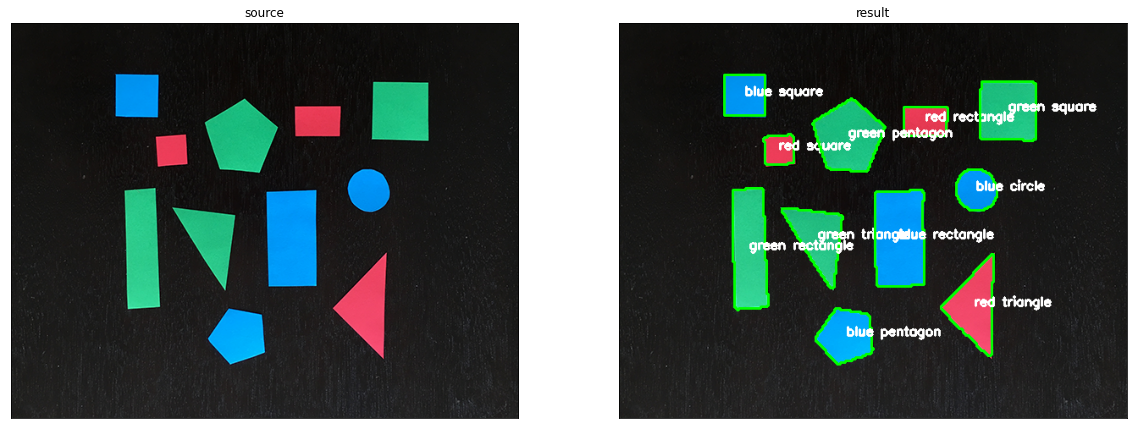

In [24]:
image_list = []
image = cv2.imread(os.path.join('images', 'q3.png'))
image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'source', 'img'])
image_list.append([cv2.cvtColor(detect_shape_color(image), cv2.COLOR_BGR2RGB), 'result', 'img'])
plotter(image_list, 1, 2, False, 20, 10, 'Q3')

# PART 4

**Point : 40 pts**

Here is for your helper functions(optional).

Please, set your structuring element here:

In [88]:
structuring_element = np.ones((51,51))

Implement this function to dilate the input image with a square element without using the OpenCV methods.

In [143]:
def your_dilate(image, structuring_element):
    '''
    Applies your dilation.
    
    Parameters:
        image (numpy.ndarray): The input image.
        structuring_element (numpy.ndarray): The structuring element must be square.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    result = image.copy()
    
    #Write your code here
#     result = cv2.filter2D(image, -1, structuring_element)
    border = 25
    image = cv2.copyMakeBorder(image, border, border, border, border, cv2.BORDER_REPLICATE)
    result = cv2.copyMakeBorder(image, border, border, border, border, cv2.BORDER_REPLICATE)
    
    for i in range(0, image.shape[0]-50):
        for j in range(0, image.shape[1]-50):
            if image[i+25, j+25] == 255:
                result[i:i+51, j:j+51] = 255
                
    for i in range(25, result.shape[0]-24):
        for j in range(25, result.shape[1]-24):
            result[i-25,j-25] = result[i,j]
            
    return result

Implement this function to erode the input image with a square element without using the OpenCV methods.

In [144]:
def your_erode(image, structuring_element):
    '''
    Applies your erosion.
    
    Parameters:
        image (numpy.ndarray): The input image.
        structuring_element (numpy.ndarray): The structuring element must be square.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    result = image.copy()
    
    #Write your code here
    border = 25
    image = cv2.copyMakeBorder(image, border, border, border, border, cv2.BORDER_REPLICATE)
    result = cv2.copyMakeBorder(image, border, border, border, border, cv2.BORDER_REPLICATE)
    
    for i in range(0, image.shape[0]-50):
        for j in range(0, image.shape[1]-50):
            if (image[i:i+51, j:j+51] == 255).all():
                result[i+25, j+25] = 255
            else:
                result[i+25, j+25] = 0
                
    for i in range(25, result.shape[0]-24):
        for j in range(25, result.shape[1]-24):
            result[i-25,j-25] = result[i,j]
    
    return result

Implement this function to dilate the input image with a square element using the OpenCV methods.

In [145]:
def cv_dilate(image, structuring_element):
    '''
    Applies OpenCV dilation.
    
    Parameters:
        image (numpy.ndarray): The input image.
        structuring_element (numpy.ndarray): The structuring element must be square.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    result = image.copy()
    
    #Write your code here
    result = cv2.dilate(image, structuring_element)
    
    return result

Implement this function to erode the input image with a square element using the OpenCV methods.

In [146]:
def cv_erode(image, structuring_element):
    '''
    Applys OpenCV erosion.
    
    Parameters:
        image (numpy.ndarray): The input image.
        structuring_element (numpy.ndarray): The structuring element must be square.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    result = image.copy()
    
    #Write your code here
    result = cv2.erode(image, structuring_element)
    
    return result

Test your implementation (don't change this cell).

time for your_dilate: 5.501712 s
time for cv_dilate: 0.002555 s
time for your_erode: 17.187223 s
time for cv_erode: 0.002511 s


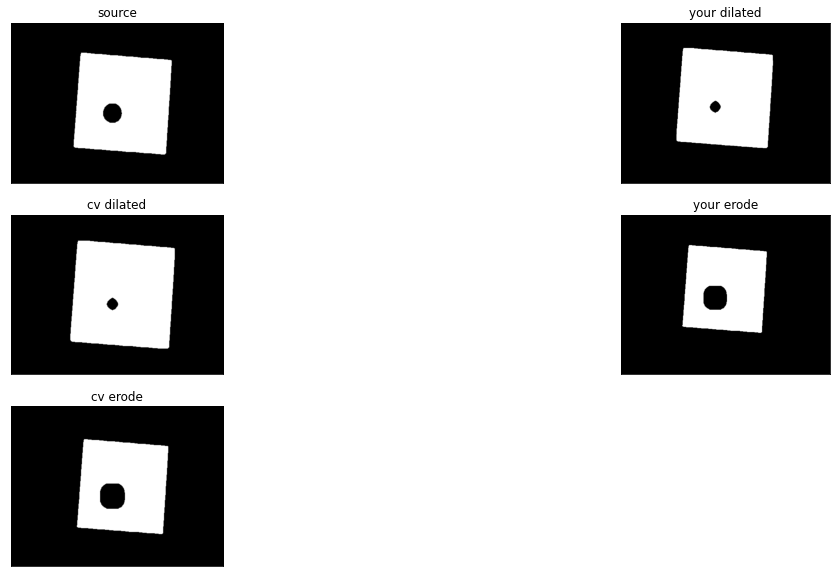

In [147]:
image_list = []
image = cv2.imread(os.path.join('images', 'q4.png'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'source', 'img'])
t1 = time.time()
y_dilate = your_dilate(image, structuring_element)
t2 = time.time()
print('time for your_dilate: %f s' % (t2 - t1))
t1 = time.time()
c_dilate = cv_dilate(image, structuring_element)
t2 = time.time()
print('time for cv_dilate: %f s' % (t2 - t1))
t1 = time.time()
y_erode = your_erode(image, structuring_element)
t2 = time.time()
print('time for your_erode: %f s' % (t2 - t1))
t1 = time.time()
c_erode = cv_erode(image, structuring_element)
t2 = time.time()
print('time for cv_erode: %f s' % (t2 - t1))
image_list.append([y_dilate, 'your dilated', 'img'])
image_list.append([c_dilate, 'cv dilated', 'img'])
image_list.append([y_erode, 'your erode', 'img'])
image_list.append([c_erode, 'cv erode', 'img'])
plotter(image_list, 3, 2, True, 20, 10, 'Q4')

To create proper files for sending in the Quera run this cell, please.

In [148]:
!python notebook_converter.py

End!!!